# Parsing APRS/AX.25 packets from audio from scratch

References:

* https://web.stanford.edu/class/ee179/labs/Lab7.html
* https://www.tapr.org/pdf/AX25.2.2.pdf
* http://www.aprs.org/doc/APRS101.PDF
* https://github.com/echicken/node-ax25/blob/es6rewrite/packet.js

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import decimate, resample, spectrogram, butter, lfilter, firwin, filtfilt, welch, convolve
from scipy.io import wavfile
from scipy.fft import fft
from math import pi
from itertools import takewhile
from pathlib import Path
from scipy.fft import fft, fftfreq, fftshift
import wave
from math import floor, ceil
from statistics import median, stdev, mean, variance

In [2]:
# APRS packets are AX.25 UI frames with a max length of 332 bytes
# Bit stuffing can add 1 bit for every 5 bits
MAX_PACKET_LENGTH = ceil(332 * 8 * (6/5))

In [3]:
# Functions to load .wav files from the assets folder and to graph amplitude and spectrum

def load_asset(name):
    def remove_dc_bias(file):
        dc_bias = sum(file)/len(file)
        return file - dc_bias

    def rescale_amplitude(file):
        # Rescale amplitude - not needed?
        return file * (50/np.max(file))
    
    base_path = Path(globals()['_dh'][0]).parent
    file_path = (base_path / "assets" / name).resolve()
    sample_rate, file = wavfile.read(file_path)
    print(f'Loaded {file_path}')
    num_channels = len(file.shape)
    length_s = round(file.shape[0]/sample_rate, 2)
    print(f'Sample rate: {sample_rate}Hz, channels: {num_channels}, samples: {file.shape[0]}, length: {length_s}s')
    
    if num_channels != 1:
        file = file[:,0]
    
    return (sample_rate, remove_dc_bias(rescale_amplitude(file)))

def save_wav(file, fs, file_path='/tmp/test.wav'):
    # normalize volume
    frames = (file * (20000 / np.max(file))).astype('int16')

    w = wave.open(file_path, mode='wb')
    w.setnchannels(1)
    w.setframerate(fs)
    w.setsampwidth(2)
    w.writeframes(frames)
    w.close()
    
    print(f'Saved file to {file_path} - {round(len(file)/fs, 2)}s @ {fs}Hz')

def show_waveform(file, fs, comment=''):
    fig, ax = plt.subplots()
    ax.plot([ n/fs for n in range(0, len(file)) ], file)
    ax.set_title(f'Waveform - {comment}')
    fig.set_figwidth(20)
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Amplitude')

def show_spectrogram(file, fs, comment=''):
    x = file
    f, t, Sxx = spectrogram(x, fs)

    fig, ax = plt.subplots()
    ax.pcolormesh(t, f, Sxx, shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.axhspan(1200-10, 1200+10, alpha=0.2, color='pink')
    ax.axhspan(2200-10, 2200+10, alpha=0.2, color='pink')
    fig.set_figwidth(20)
    ax.set_ylim([0,3000])
    ax.set_title(f'Spectrogram with 1200Hz and 2200Hz highlighted - {comment}')


In [4]:
# Functions to find activity - Check for parts of the file where 1200Hz and 2200Hz are active

def find_interestingness(x, fs, freqs=(1200, 2200), freqs_width=50):
    # Use Welch's method to find spectral efficiency
    f, Pxx_den = welch(x, fs, nperseg=1024)
    
    # Select the indexes where interested in (around the two FSK frequencies)
    indexes_to_sum = [ idx for (idx, freq) in zip(range(0, len(f)), f) if (freqs[0] - freqs_width) < freq < (freqs[0] + freqs_width) or (freqs[1] - freqs_width) < freq < (freqs[1] + freqs_width) ]

    return sum(map(lambda idx: Pxx_den[idx], indexes_to_sum))

def find_activity(file, fs, freqs=(1200, 2200)):
    """Scan the audio file and return a list of indices where specified frequencies are active"""
    bucket_length_s = 0.2
    bucket_length_samples = round(fs*bucket_length_s)
    overlap = bucket_length_samples*2

    print(f'bucket length: {bucket_length_s}s, {bucket_length_samples} per bucket, overlap: {overlap}')

    range_starts = range(0, len(file), bucket_length_samples)

    interestingness = [ (start, start+bucket_length_samples, find_interestingness(file[start:start+bucket_length_samples], fs)) for start in range_starts ]
    threshold = median(map(lambda x: x[2], interestingness)) * (3/2)
    show_waveform(list(map(lambda x: x[2], interestingness)), 1/bucket_length_s, f'Activity for {freqs}Hz. Baseline: {threshold}.')

    interesting_parts = [ (start, end) for start, end, level in interestingness if level > threshold ]
    interesting_parts_starts = [ curr[0] for curr, prev in zip(interesting_parts, [(None, None)] + interesting_parts[:-1]) if curr[0] != prev[1] ]

    return interesting_parts_starts


In [5]:
# Functions to decode bits

def byte_to_char(b):
    """Return the character represented by the byte b (as a list of 1's and 0's) with LSB first"""
    if len(b) < 8:
        return '?'

    bv = b[0]*1 + b[1]*2 + b[2]*4 + b[3]*8 + b[4]*16 + b[5]*32 + b[6]*64 + b[7]*128
    return chr(bv)

def char_to_byte(c):
    """Convert the character c to a byte (as a list of 1's and 0's) with LSB first"""
    return [ int(x) for x in f'{ord(c):b}'.zfill(8)[::-1] ]


def chunk(l, n):
    """Chunk a list l into chunks (lists) of length n"""
    n = max(1, n)
    return list(l[i:i+n] for i in range(0, len(l), n))

def bit_stuff(arr):
    """Perform bit stuffing on arr: add a zero after five ones in a row"""
    arr = list(arr)
    i = 0
    while i < len(arr):
        if i >= 4 and arr[i-4] == 1 and arr[i-3] == 1 and arr[i-2] == 1 and arr[i-1] == 1 and arr[i] == 1:
            # We have 5 ones in a row => time to stuff
            arr.insert(i+1, 0)

        i = i + 1

    return np.array(arr)

def bit_destuff(arr):
    """Perform bit de-stuffing on arr: remove a stuffed zero after five ones in a row"""
    arr = list(arr)
    i = 0
    while i < len(arr):
        if i >= 4 and arr[i-5] == 1 and arr[i-4] == 1 and arr[i-3] == 1 and arr[i-2] == 1 and arr[i-1] == 1:
            if (arr[i] != 0):
                raise ValueError('Bit de-stuffing: I had 5 ones in a row during bit de-stuffing, and expected a 0 but got {arr[i]} at index {i}')
            
            # We have 5 ones in a row => time to remove stuffed zero
            arr.pop(i)
            i = i + 1

        i = i + 1

    return np.array(arr)

def nrzi_decode(arr):
    """Perform non-return to zero inverted decoding"""
    return [ 1 if x == y else 0 for x, y in zip([0] + arr, arr[1:] + [0])]

def parse_packet(pack):
    pack = chunk(pack, 8)
    
    def shift_byte(byte):
        return list(byte)[1:] + [0]

    def parse_address(b):
        # Format: 0SSIDRRC
        # See https://www.tapr.org/pdf/AX25.2.2.pdf, page 12
        last_address_byte = b[6]

        return {
            "callsign": ''.join(map(lambda byte: byte_to_char(shift_byte(byte)), b[0:6])).rstrip(),
            "ssid": last_address_byte[1] + last_address_byte[2] * 2 + last_address_byte[3] * 4 + last_address_byte[4] * 8,
            "reserved_bits": last_address_byte[5:7],
            "command_response": True if last_address_byte[7] else False
        }

    
    # Digipeater addresses are 7 characters long
    # A '1' in the left-most position of the byte (LBS) signifies the digipeater list is over
    number_of_digipeaters_addresses = len(list((takewhile(lambda offset: pack[14::7][offset][0] == 0, range(0,9)))))
    
    return {
        "destination": parse_address(pack[0:7]),
        "source": parse_address(pack[7:14]),
        "digipeaters": list(map(lambda digipeater_offset: parse_address(pack[14+digipeater_offset*7:14+digipeater_offset*7+7]), range(0, number_of_digipeaters_addresses))),
        "control_field": pack[14+number_of_digipeaters_addresses*7],
        "protocol_id": pack[15+number_of_digipeaters_addresses*7],
        "information": ''.join(list(map(lambda b: byte_to_char(b), pack[16+number_of_digipeaters_addresses*7:]))[:-2]),
        "frame_check_sequence": pack[-2:]
    }

def decode_bits(bits, debug=False):
    db = nrzi_decode(bits)
    frame_starts = [ sum([not(s0), s1, s2, s3, s4, s5, s6, not(s7)]) for s0,s1,s2,s3,s4,s5,s6,s7 in zip(db, db[1:], db[2:], db[3:], db[4:], db[5:], db[6:], db[7:])]

    frame_start_indices = [ idx for idx, x in enumerate(frame_starts) if x == 8 ]

    [packet_start, packet_end] = [ (curr + 8, next) for curr, next in zip(frame_start_indices, frame_start_indices[1:]) if curr != next - 8 ][0]
    
    packet = np.array(db[packet_start:packet_end]).astype(int)
    
    try:
        packet = bit_destuff(packet)
    except:
        return None

    if debug:
        print(f'Found frame starts at {frame_start_indices}')
        print(f'Packet starts at {packet_start}, ends at {packet_end}')

        fig, ax = plt.subplots()
        fig.set_figwidth(20)
        ax.plot(packet)
        ax.set(title='Data packet')
        plt.show() 
    
    return parse_packet(packet)

In [6]:
def create_eye_diagram(file, fs, start, offset, freq=1200):
    n_samples = 256
    width = int(fs/freq)
    half_width = int(width/2)
    
    n1 = start + offset
    n2 = n1 + width * n_samples

    eyed = np.reshape(file[n1-half_width:n2-half_width], (width, n_samples), 'F')

    fig, ax = plt.subplots()
    ax.plot(range(-half_width, half_width), eyed)
    ax.set(title=f'Eye diagram - {n_samples} samples at {freq}Hz, width {width}. From sample {n1} to {n2} - offset {offset}')
    ax.grid()

def resample_file(file, current_sample_rate, desired_sample_rate):
    return resample(file, int((desired_sample_rate/current_sample_rate) * len(file)))

def convolve_over_file(file):
    t20 = np.array([ x/20 for x in range(-10,10) ]).astype(np.longdouble)
    mf1200 = np.exp(1j*2*pi*t20*1.0)
    mf2200 = np.exp(1j*2*pi*t20*1.8)

    d12 = np.convolve(file, mf1200,'same')
    d22 = np.convolve(file, mf2200,'same')
    
    # return abs(d22)# + abs(d22)
    return abs(d12) - abs(d22)

def find_best_offset(file, start, fs, freq=1200):
    # Find the best offset to sample file at freq
    # i.e. where the eye diagram is open the most
    # i.e. offset to correct phase shift
    
    width = int(fs/freq)
    n = 256

    # Return the index where the standard deviation is the biggest
    stdevs = [ stdev(file[start + offset:start + offset + (width*n):20]) for offset in range(0, width) ]
    return stdevs.index(max(stdevs))

def process_possible_packet(possible_packet, current_fs, debug=False):
    if debug:
        show_spectrogram(possible_packet, current_fs)

    fs =  24000
    processed_packet = resample_file(possible_packet, current_fs, fs)
    convolved_packet = convolve_over_file(processed_packet)    
    offset = find_best_offset(convolved_packet, 1000, fs)
    
    if debug:
        create_eye_diagram(convolved_packet, fs, start=1000, offset=offset)
    
    bits = convolved_packet[offset::20] > 0
    
    return decode_bits(bits, debug)

Loaded /home/thomas/code/aprs-ax25-from-scratch/assets/aprs_audacity_very_long.wav
Sample rate: 44100Hz, channels: 1, samples: 68704301, length: 1557.92s
bucket length: 0.2s, 8820 per bucket, overlap: 17640
activity at  [167580, 6420960, 6897240, 7399980, 8149680, 8334900, 8722980, 9904860, 10275300, 10610460, 10954440, 11492460, 12674340, 12930120, 13521060, 13909140, 14332500, 14394240, 14605920, 14896980, 15523200, 16255260, 18927720, 21203280, 21503160, 31522680, 32351760, 35606340, 35906220, 36876420, 37714320, 38208240, 38896200, 46790100, 47954340, 49127400, 49877100, 50362200, 51852780, 52990560, 54472320, 54684000, 57391740, 59808420, 60090660, 60417000, 60866820, 64809360, 65109240, 65329740, 68116860, 68222700]
Found 52 possible packets


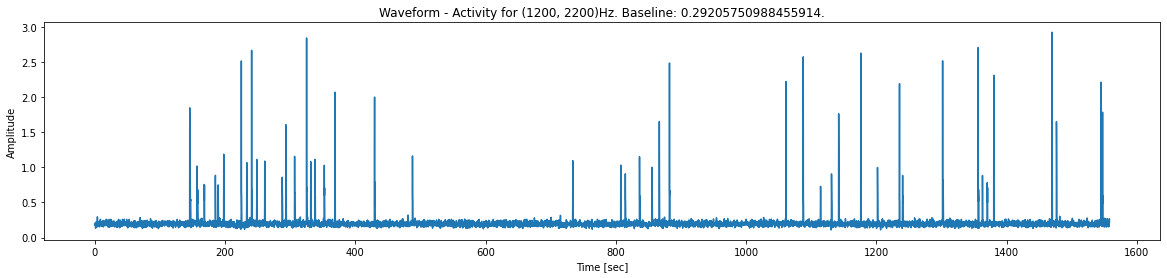

In [7]:
# Load the file
file_sample_rate, file = load_asset('aprs_audacity_very_long.wav')

# show_spectrogram(file, file_sample_rate, 'full original file')
# show_waveform(file, file_sample_rate, 'full original file')

# Scan the input file and split to possible packets

activity = find_activity(file, file_sample_rate)
print('activity at ', activity)

max_len = ceil((MAX_PACKET_LENGTH/1200) * file_sample_rate)
possible_packets = [ np.array(file[activity_start:activity_start+max_len]) for activity_start in activity ]

print(f'Found {len(possible_packets)} possible packets')

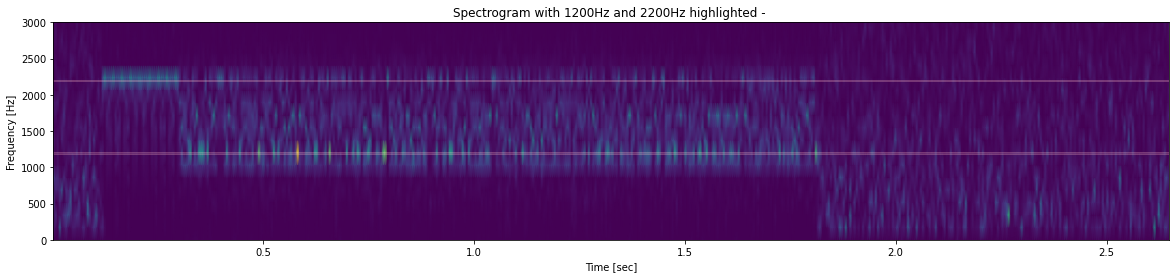

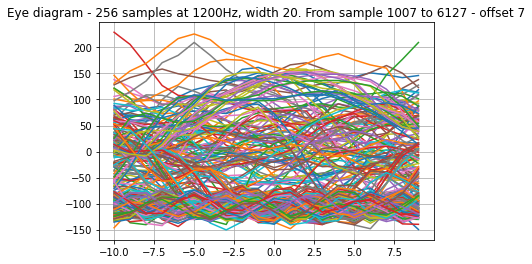

In [8]:
parsed = [process_possible_packet(possible_packet, file_sample_rate, debug=True) for possible_packet in possible_packets[2:3] ]

/home/thomas/.cache/pypoetry/virtualenvs/python-ax25-experiment-H0RPaX0S-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


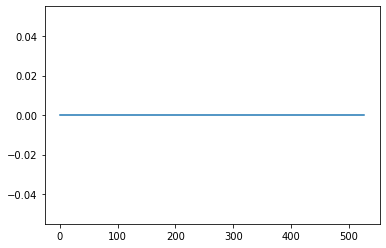

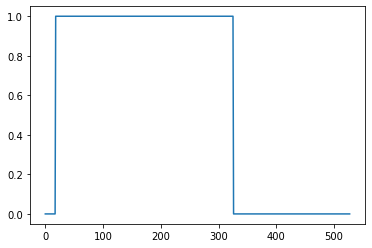

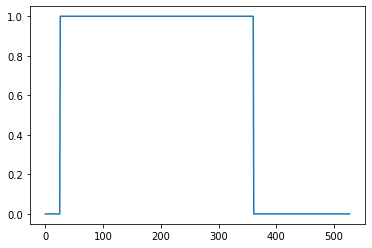

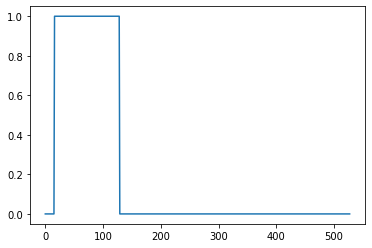

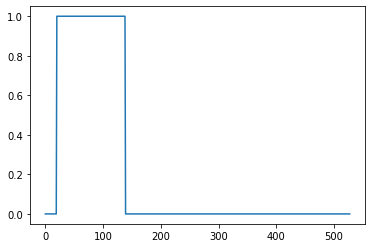

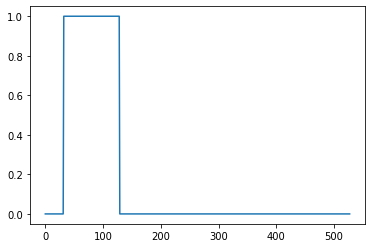

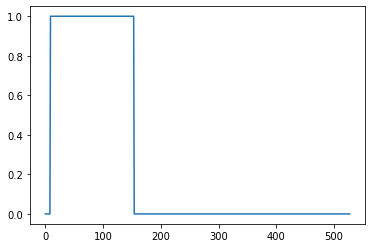

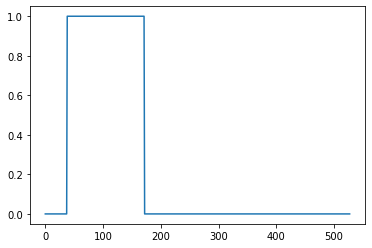

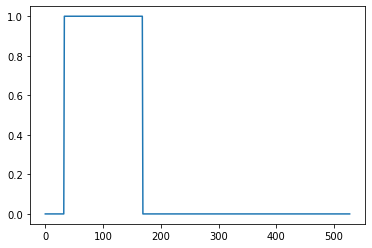

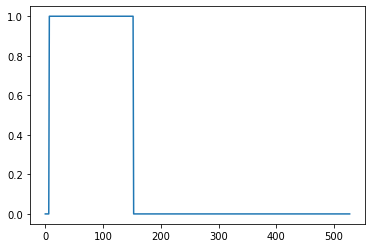

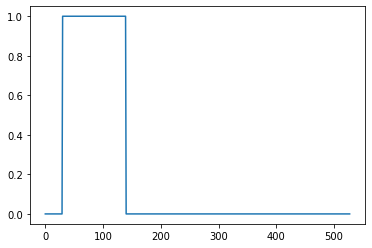

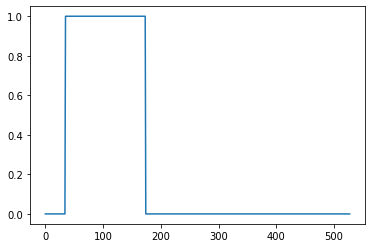

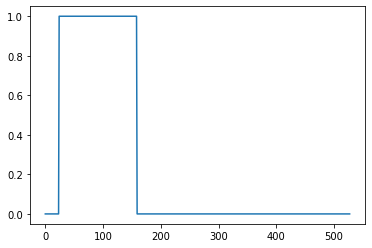

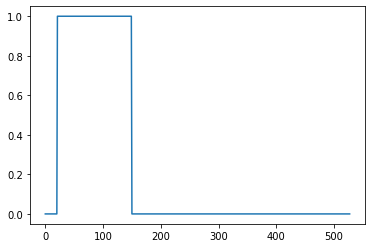

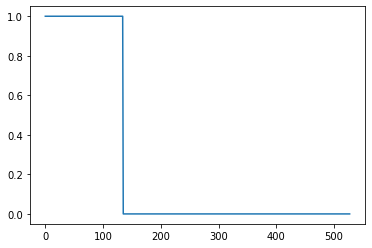

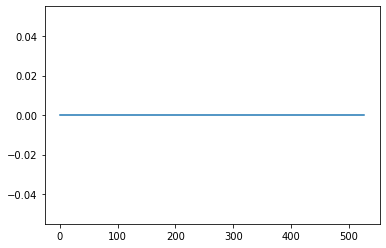

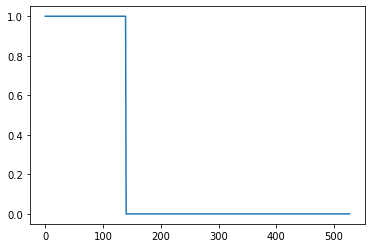

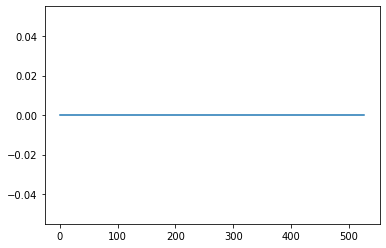

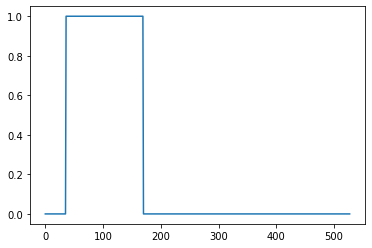

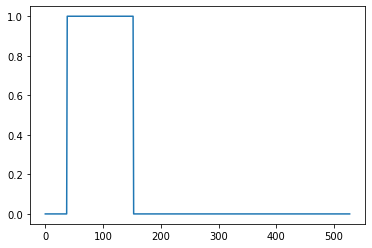

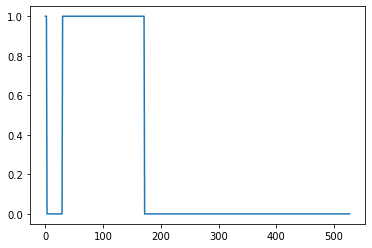

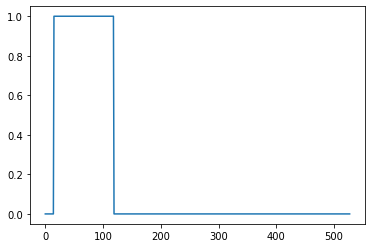

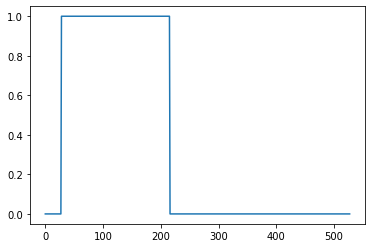

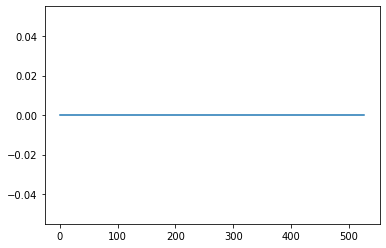

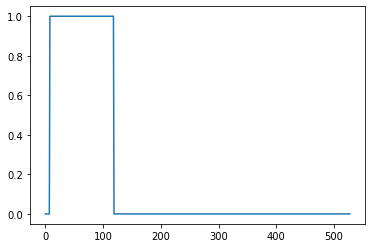

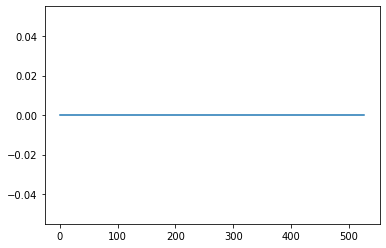

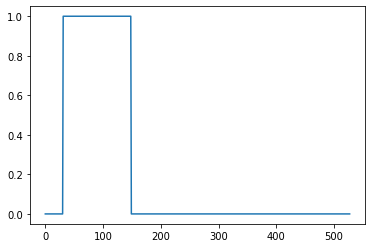

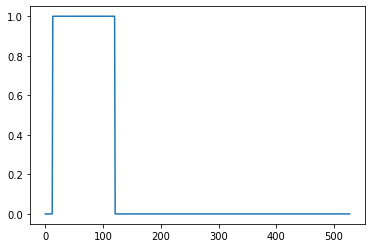

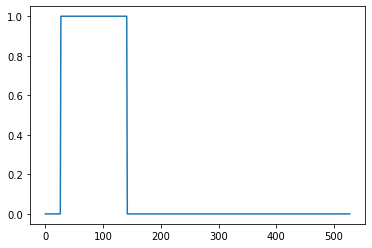

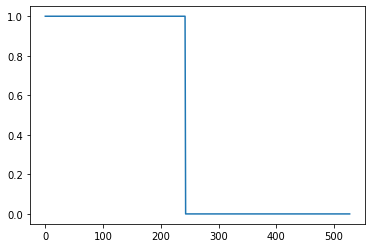

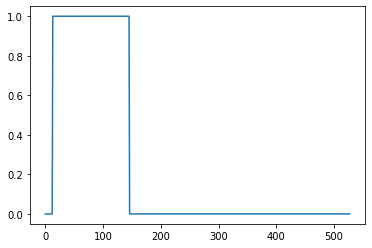

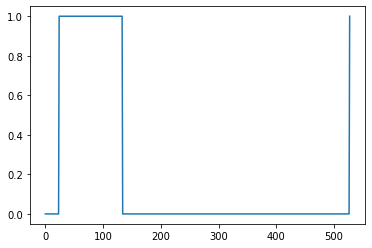

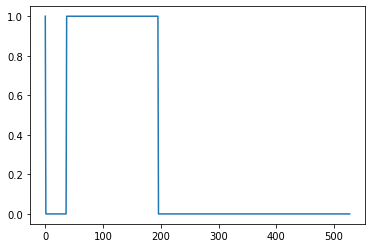

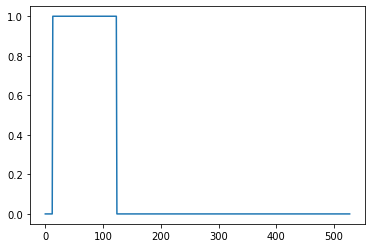

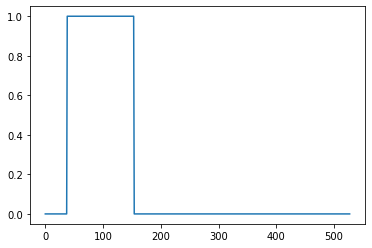

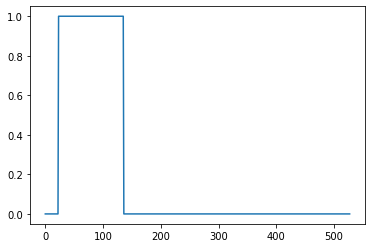

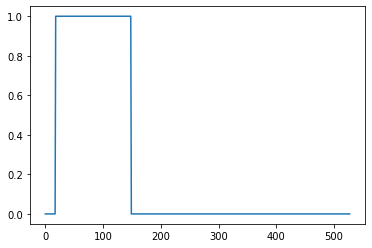

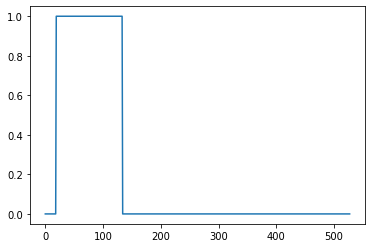

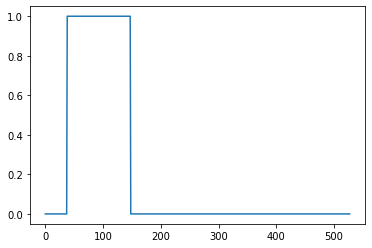

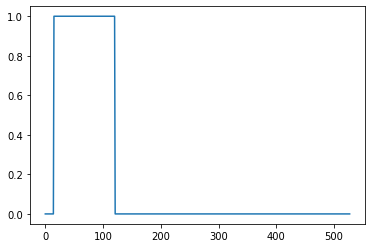

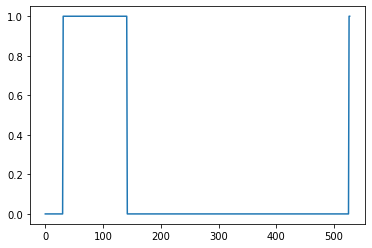

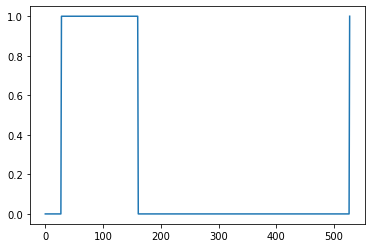

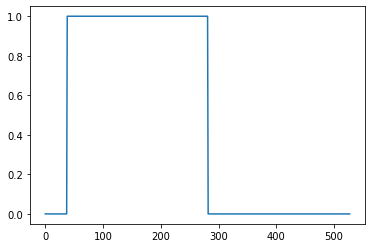

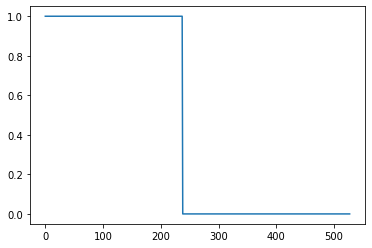

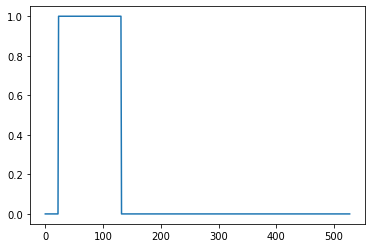

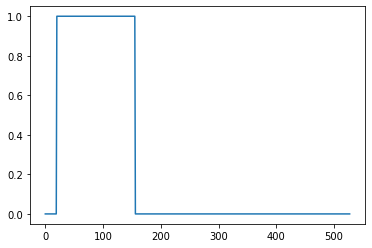

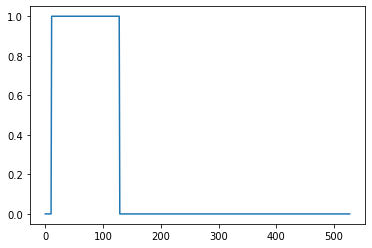

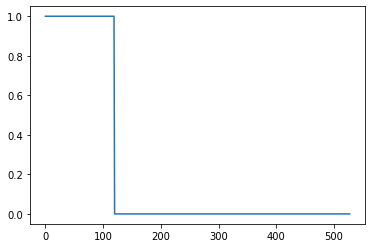

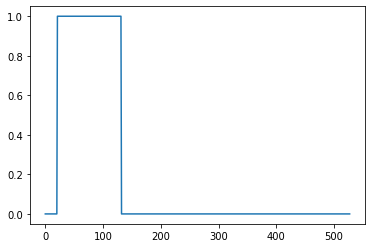

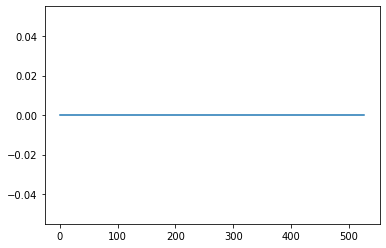

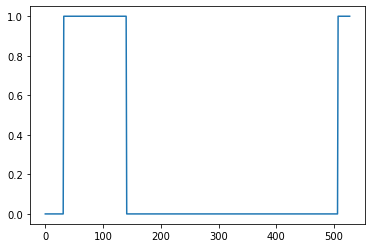

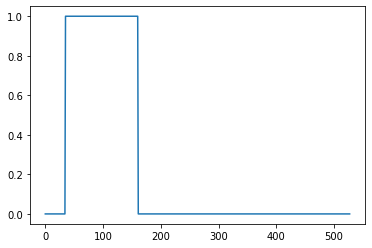

In [9]:
for p in possible_packets:
    fig, ax = plt.subplots()
    f, t, Sxx = spectrogram(p, file_sample_rate)
    ax.plot(convolve(Sxx[13] + Sxx[7] - (Sxx[1]+Sxx[2]+Sxx[3]+Sxx[4]+Sxx[5]), np.array([0.5,0.5,1,1,1,0.5,0.5])) > 0)
#     ax.plot((Sxx[1]+Sxx[2]+Sxx[3]+Sxx[4]+Sxx[5]))

In [10]:
[ idx for idx, value in enumerate(convolve(Sxx[13] + Sxx[7] - (Sxx[1]+Sxx[2]+Sxx[3]+Sxx[4]+Sxx[5]), np.array([0.25,0.5,0.25]))) if value > 0]

[34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158]

In [11]:
convolve(Sxx[13] + Sxx[7] - (Sxx[1]+Sxx[2]+Sxx[3]+Sxx[4]+Sxx[5]), np.array([0.25,0.5,0.25]))

array([-1.25829094e-01, -2.96601431e-01, -2.40820095e-01, -1.41640861e-01,
       -1.44745332e-01, -1.39433658e-01, -1.39923008e-01, -1.80382115e-01,
       -2.49522786e-01, -3.19389526e-01, -3.34862175e-01, -2.62844423e-01,
       -2.18359084e-01, -1.97140904e-01, -1.51184212e-01, -2.23658758e-01,
       -2.93589835e-01, -2.31157760e-01, -1.80653104e-01, -2.00297280e-01,
       -2.49133814e-01, -2.27782684e-01, -2.46210835e-01, -3.08854075e-01,
       -2.60089892e-01, -2.52188938e-01, -3.03907273e-01, -3.15040287e-01,
       -3.57642478e-01, -3.82704074e-01, -3.45678796e-01, -3.28488844e-01,
       -2.60754702e-01, -5.01328775e-04,  3.99410227e-01,  7.09162933e-01,
        7.33313714e-01,  5.55883860e-01,  4.89515125e-01,  6.49803302e-01,
        7.57315946e-01,  6.05464642e-01,  4.76489407e-01,  6.00269681e-01,
        7.22290309e-01,  6.07030872e-01,  4.56576270e-01,  5.79693471e-01,
        7.91561994e-01,  6.98774700e-01,  5.06973952e-01,  6.08461187e-01,
        8.17786320e-01,  

In [12]:
int(t[28992]*file_sample_rate)

IndexError: index 28992 is out of bounds for axis 0 with size 522

In [13]:
f, t, Sxx = spectrogram(file, file_sample_rate)

interestingness = convolve(Sxx[13] + Sxx[7] - (Sxx[1]+Sxx[2]+Sxx[3]+Sxx[4]+Sxx[5]), np.array([0.5,1,1,1,1,1,1,1,1,1,0.5]))
threshold = 0

active = [ idx for idx, value in enumerate(interestingness > threshold) if value ] 

#fig, ax = plt.subplots()
#ax.plot()

# interesting_parts = [ (start, end) for start, end, level in interestingness if level > threshold ]
# interesting_parts_starts = [ curr[0] for curr, prev in zip(interesting_parts, [(None, None)] + interesting_parts[:-1]) if curr[0] != prev[1] ]

In [47]:
activity = [ int(t[prev]*file_sample_rate) for prev, curr in zip(active[1:],active) if curr + 1 != prev and prev < len(t) ]
possible_packets = [ np.array(file[activity_start-1000:activity_start+max_len]) for activity_start in activity ]

len(possible_packets)

46

Found frame starts at [2, 10, 18, 34, 42, 50, 66, 74, 82, 90, 98, 106, 114, 122, 130, 138, 146, 154, 170, 178, 194, 202, 798, 1421, 2019, 2154, 2288, 2522, 2615, 2810, 2924, 2941, 2997, 3005]
Packet starts at 26, ends at 34


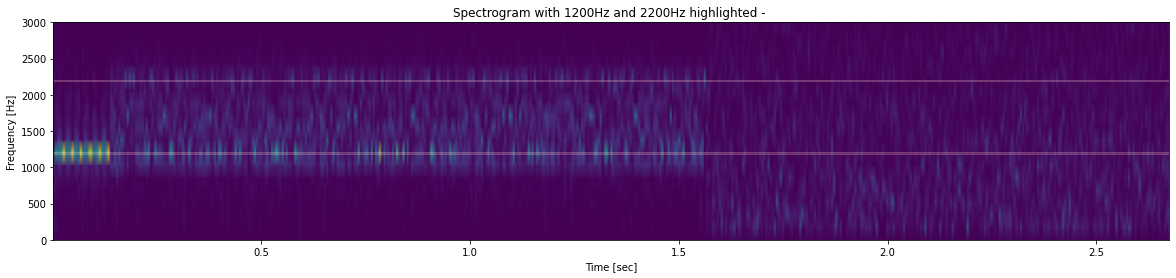

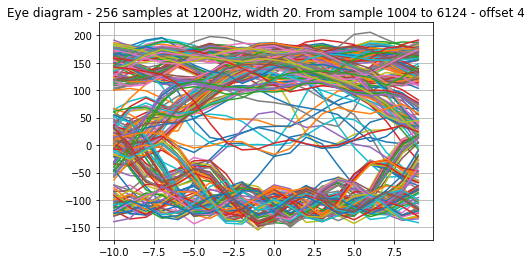

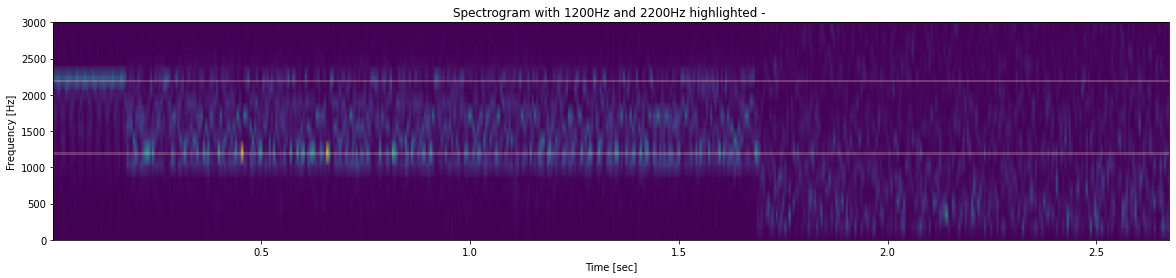

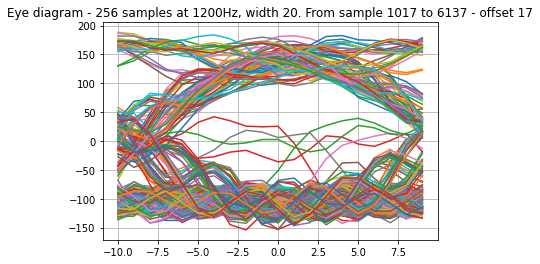

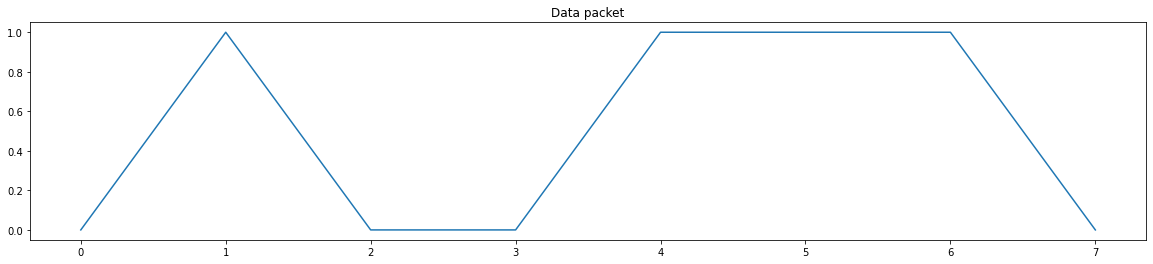

IndexError: list index out of range

In [48]:
parsed = [process_possible_packet(possible_packet, file_sample_rate, debug=True) for possible_packet in possible_packets[0:10] ]

Found frame starts at [7, 15, 23, 31, 39, 47, 55, 71, 79, 87, 95, 103, 111, 119, 127, 135, 143, 159, 167, 175, 183, 191, 199, 699, 1050, 1108, 1123, 1353, 2122, 2203, 2348, 2482, 2548, 2679, 2812, 2976, 3093]
Packet starts at 63, ends at 71


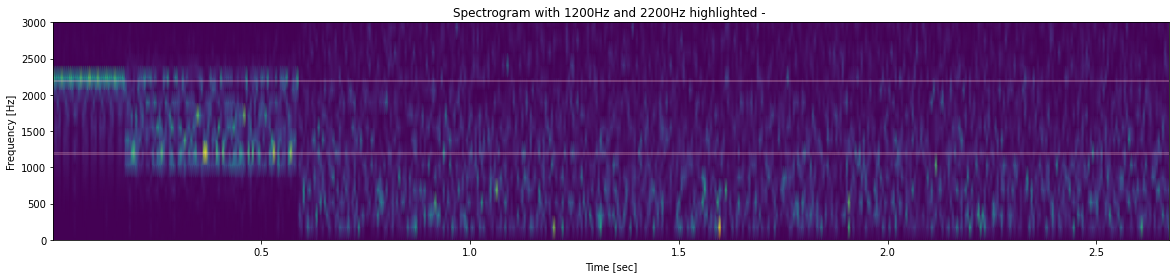

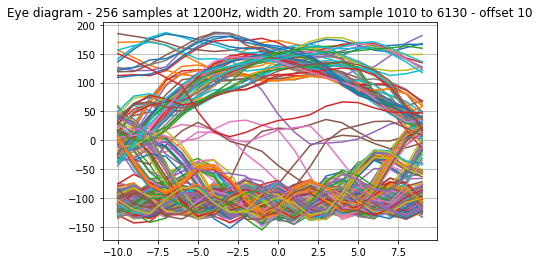

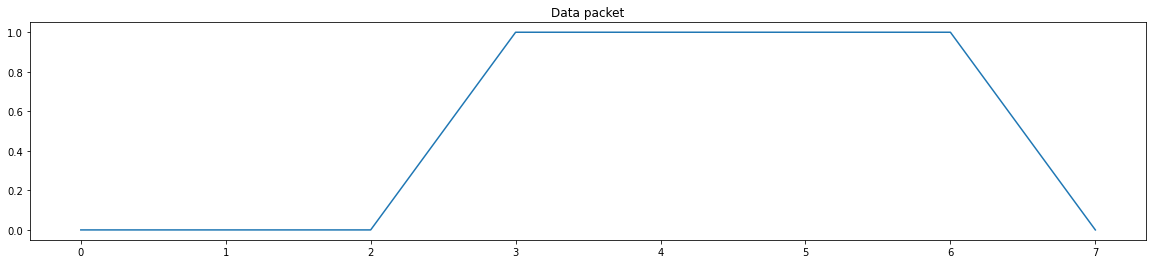

IndexError: list index out of range

In [59]:
process_possible_packet(possible_packets[4], file_sample_rate, debug=True)

In [ ]:
TODO only consider a frame a start of the packet if the distance to the next 01111110 frame is big enough